# Answering Business Questions using SQL

In this project, we will use the Chinook database (provided as a db file called *chinook.db*) to answer various questions. Below is a copy of the database schema.
<img src="chinook-schema.svg">

In [318]:
# Import the libraries needed for this project
import sqlite3
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [319]:
# Create a few helper functions

def run_query(query):
    """Takes in a query and prints the results as a dataframe"""
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)
    
def run_command(query):
    """Executes a query; used for queries that don't return tables"""
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None # autocommit any changes
        conn.execute(query)
    
def show_tables():
    """Returns a list of all tables and views in the database"""
    q = """
        SELECT name, type
        FROM sqlite_master
        WHERE type IN ("table", "view"); 
        """
    return run_query(q)   

In [320]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blue    |


The record label specializes in artists from the USA, so let's find out which genres sell the best in the USA.

In [321]:
# A query to showing how many tracks were sold per genre
q = """
    SELECT g.name genre, SUM(il.quantity) numbers_of_tracks_sold
    FROM track t 
    JOIN invoice_line il ON t.track_id = il.track_id
    JOIN genre g ON g.genre_id = t.genre_id
    JOIN invoice i ON i.invoice_id = il.invoice_id
    WHERE i.billing_country = "USA"
    GROUP BY genre
    ORDER BY 2 DESC;
"""
genre_sales_usa = run_query(q)

# Add a column to show the Percentage Sold for each genre
genre_sales_usa["percentage_sold"] = genre_sales_usa["numbers_of_tracks_sold"] / genre_sales_usa["numbers_of_tracks_sold"].sum() 

genre_sales_usa

,genre,numbers_of_tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


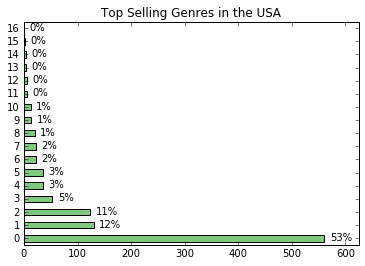

In [322]:
# Plot a visual representation of the chart shown above

genre_sales_usa["numbers_of_tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "numbers_of_tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

Comparing the tables and charts to the list of albums to be added to the store, we would advise to select the following artists:
1. Red Tone (Punk)
2. Slim Jim Bites (Blues)
3. Meteor and the Girls (Pop)


## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We want to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [323]:
# A query showing Total Sales, Max Sale, and total sales count
q = """
SELECT e.employee_id id, (e.first_name||" "||e.last_name) name, 
    e.hire_date, SUM(i.total) total_sales, 
    COUNT(i.invoice_id) sales_frequency
FROM employee e 
JOIN customer c ON e.employee_id = c.support_rep_id
JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1;
"""
sales = run_query(q)
sales

,id,name,hire_date,total_sales,sales_frequency
0,3,Jane Peacock,2017-04-01 00:00:00,1731.51,212
1,4,Margaret Park,2017-05-03 00:00:00,1584.00,214
2,5,Steve Johnson,2017-10-17 00:00:00,1393.92,188


In [324]:
# A query showing the home country of the Sales Support Agent, which
# country provide the most orders
q = """
SELECT e.employee_id id, (e.first_name ||" "|| e.last_name) name, 
    e.country home_country, c.country customer_country_freq, 
    COUNT(c.country) order_frequency
FROM employee e 
JOIN customer c ON e.employee_id = c.support_rep_id
JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1, 4
ORDER BY COUNT(billing_country) DESC
LIMIT 3
;
"""
freq = run_query(q)
freq

,id,name,home_country,customer_country_freq,order_frequency
0,4,Margaret Park,Canada,USA,63
1,3,Jane Peacock,Canada,Canada,47
2,5,Steve Johnson,Canada,USA,43


In [325]:
# merge the two tables
sales_breakdown = sales.merge(freq, left_on='id', right_on='id',
          suffixes=('_left', '_right'))

# drop the 'id' column and the extra 'name' column
sales_breakdown = sales_breakdown.drop(columns=['name_right','id'])
sales_breakdown.rename(columns={'name_left':'name'}, inplace=True)
sales_breakdown

,name,hire_date,total_sales,sales_frequency,home_country,customer_country_freq,order_frequency
0,Jane Peacock,2017-04-01 00:00:00,1731.51,212,Canada,Canada,47
1,Margaret Park,2017-05-03 00:00:00,1584.00,214,Canada,USA,63
2,Steve Johnson,2017-10-17 00:00:00,1393.92,188,Canada,USA,43


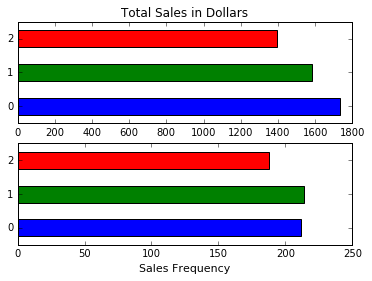

In [326]:
# Plot Total Sales and Sales Frequency

fig, axes = plt.subplots(2)
sales_breakdown["total_sales"].plot(kind="barh", ax=axes[0])
axes[0].set_title("Total Sales in Dollars")

sales_breakdown["sales_frequency"].plot(kind="barh", ax=axes[1])
axes[1].set_xlabel("Sales Frequency", fontsize=11)

plt.show()

From the table and plot above, we see that Jane Peacock has the most total dollar amount in sales, even though Margarent Park has highest sales frequency. This may be because that Jane was at the company one month prior before Margarent was hired.

Jane gained most of her sales from customers in Canada while Margarent Park gained most of her sales from customers in USA. Both of the Sale Support Agents reside in Canada.


## Analyzing Sales by Country

Next, we analyze the sales data for customers from each different country. Because there are a number of countries with only one customer, we group these customers as "Other" and make it appear at the bottom of our analysis. 

In [327]:
# A query that uses a temp table to help identify the countries that have 
# only 1 distinct customer and includes columns needed for our analysis
sales_by_country = """ 
WITH country_or_other AS (
    SELECT
        CASE
             WHEN (
                SELECT count(*)
                FROM customer
                WHERE country = c.country
                ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        i.*
    FROM customer c
    JOIN invoice i ON c.customer_id = i.customer_id
    )

SELECT country, customers, total_sales, 
        average_order, customer_lifetime_value 
FROM 
    (
    SELECT country, COUNT(DISTINCT customer_id) customers, 
        SUM(total) total_sales, 
        AVG(total) average_order,
        SUM(total)/COUNT(DISTINCT customer_id) customer_lifetime_value,
        CASE 
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    )
;"""

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


From the table above, we can see that USA customers generate the most sales as most of our total customers are from the USA.


## Visualizing Sales by Country

Using the data from the table above, we create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

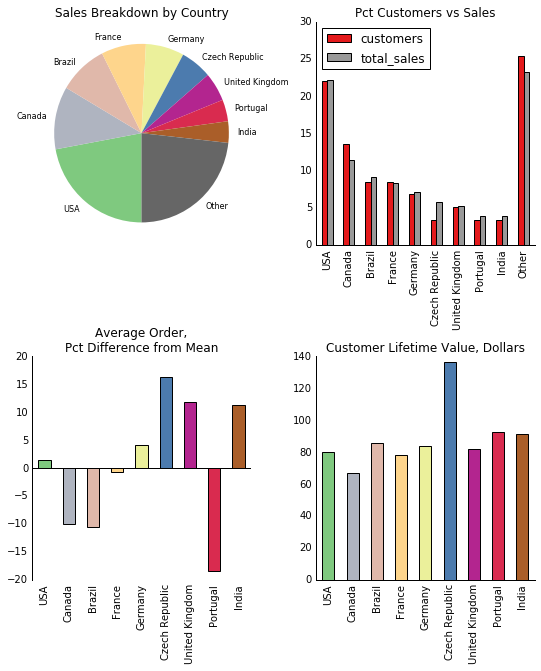

In [328]:
# create visual representations based on the table above

country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left - use the 'total_sales' column to show Sales Breakdown by Country 
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right - use the 'customers' and 'total_sales' columns to show each 
# country's percentage based on the total of the individual columns 
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left - use the 'average_order' column to calculate the Percent
# Difference from the Mean
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right - shows bar graph representation of the 
# 'customer_lifetime_value' column 
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the visual representation of the data above, there may be opportunity in the following countries:

1. Czech Republic
2. United Kingdom
3. India

Please keep in mind that the amount of data from each of these countries is relatively low. Therefore, we advise to exercise caution in spending too much money on new marketing campaigns, as the sample size is not large enough to give high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.


## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks

Chinook Management is considering changing their purchasing strategy to save money. The strategy they are considering is to purchase **only** the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue. Note, we will ignore albums consisting of only a few tracks, as they are likely to be purchased by customers as part of a collection of individual tracks.

In [329]:
# a query that identifies how many invoices were album purchases
albums_vs_tracks = """
SELECT 
    album_purchased, 
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                                        SELECT COUNT(*) FROM invoice
                                        ) percent
FROM
(
    SELECT invoices.*, albums.total_tracks, 
        CASE 
            WHEN invoices.tracks_purchased == albums.total_tracks THEN "yes"
            ELSE "no"
        END AS "album_purchased"
    FROM 
    (
        SELECT il.invoice_id, al.album_id, COUNT(il.track_id) tracks_purchased
        FROM invoice_line il
        JOIN track t ON t.track_id = il.track_id
        JOIN album al ON t.album_id = al.album_id
        GROUP BY 1, 2
    ) invoices 
LEFT JOIN 
    (
        SELECT al.album_id, COUNT(t.track_id) total_tracks
        FROM track t
        JOIN album al ON t.album_id = al.album_id
        GROUP BY al.album_id
        HAVING COUNT(t.track_id) > 2 
    ) albums 
        ON invoices.album_id = albums.album_id
        GROUP BY invoice_id        
)
GROUP BY album_purchased
;"""

run_query(albums_vs_tracks)

,album_purchased,number_of_invoices,percent
0,no,503,0.819218
1,yes,111,0.180782


Based on the table above, album purchases account for 18.1% of purchases. In response, we would advise against purchasing only select tracks from albums from record companies, since there is potential to lose about one fifth of revenue.